# Imports

In [1]:
import time
import os,pickle
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common.misc import autopickle

from NearFieldOptics import Materials as M

import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import RotationalMoM as RotMOM
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
#from ProbeCavityEigenfields import RotationalMoM_new as RotMOMnew

#import numba
#eload(np) 
#reload(numba) 
#print('Numba version:',numba.__version__)
print('Numpy version:',np.__version__) # version 0.6 appears not compatible with numpy 1.22 - 1.24

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

# Build probe

In [2]:
a_nm=20
a=a_nm*1e-7 #in cm
L=24e-4 #probe length in cm, assuming cantilever thickness 4e-4 #Arrow probe: https://www.nanoworld.com/tapping-mode-reflex-coated-afm-tip-arrow-ncr
L_microns=L*1e4
taper_angle=15 # Arrow probe: https://www.researchgate.net/figure/SEM-image-of-an-AFM-tip-attached-to-cantilever_fig6_224406883
geometry='cone'

WL_THz=300e-4 #300 microns wavelength
freq_THz=1/WL_THz
freq=30*freq_THz # 30 THz

Nsubnodes=2
Nnodes=244

probe_name = '%s_a=%inm_taper=%i_L=%imicrons_Nnodes=%i'%(geometry.upper(),a_nm,taper_angle,L_microns,Nnodes)
#probe_name = 'MidIRHyperboloid_FreqDepNormalization_L=%imicrons'%(L*1e4,)
print('Building probe %s...'%probe_name)

Building probe HYPERBOLOID=20nm_L=23microns_Nnodes=488...


<__init__._ProbesCollection.__setitem__>:
	Registering probe "Hyperboloid=20nm_L=23microns_Nnodes=488"...
Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(HYPERBOLOID=20nm_L=23microns_Nnodes=488)_Probe.pickle"!


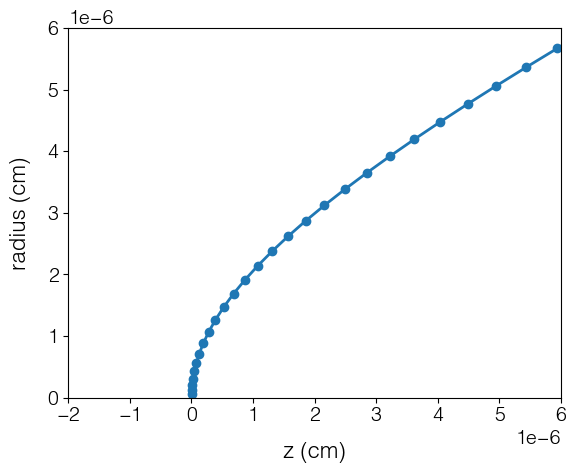

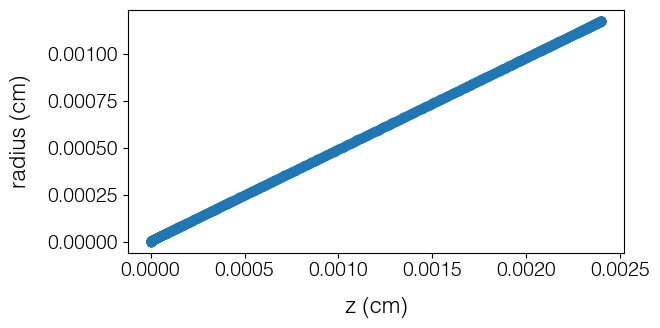

In [3]:
# Load the probe or build the probe
recompute = False
overwrite = False
try:
    if recompute: raise ValueError
    P = PCE.load(probe_name,PCE.Probe)
except (FileNotFoundError,ValueError): 

    P=PCE.Probe(Nnodes=Nnodes,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                     a=a,taper_angle=taper_angle,geometry=geometry,
                freq=freq,gap=a,name=probe_name)

    RotMOM.quadlimit = int(1e4)
    #Zmirror = P.get_mirror_impedance(k=0,kappa_min=.1/L,recompute=False,sommerfeld=True,Nkappas=244*8)
    Zmirror = P.get_mirror_impedance(sommerfeld=False)
    #Zself = P.get_self_impedance(k=P.get_k(),recompute=True)
    rhos,Js = P.solve_eigenmodes(condition_ZM=True,condition_ZS=False,ZMthresh=0,recompute_impedance=False)
    
    try: PCE.save(P,overwrite=overwrite)
    except OSError: pass
    
ztip=P.get_gap()
zs=P.get_zs()
Rs=P.get_radii()
k=P.get_k()
    
plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.xlim(-a,3*a)
plt.ylim(0,3*a)
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

plt.figure()
Rs.plot(marker='o')
plt.gca().set_aspect('equal')
plt.ylabel('radius (cm)')
plt.xlabel('z (cm)')

RotMOM.quadlimit = int(1e4)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=0,nonsingular=False,recompute=True)
#Zmirror = P.get_mirror_impedance(k=P.get_k(),farfield=False,recompute=True,sommerfeld=True,Nkappas=244*8,rp=rp_au,\
#                                kappa_min=P.get_k()*.01)

(0.0, 15.0)

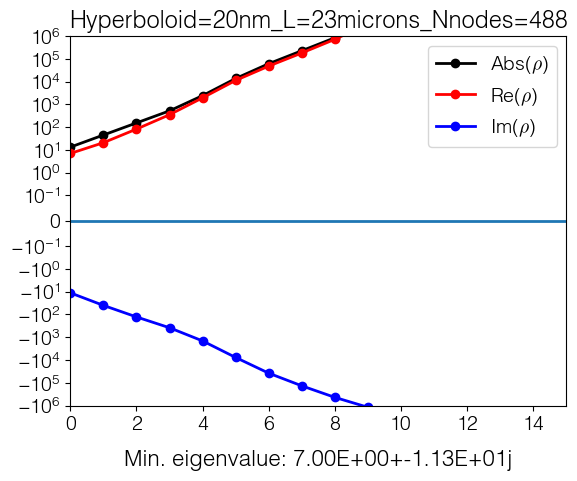

In [4]:
P.plot_eigenrhos()
plt.xlim(0,15)

# Probe Gap Spectroscopy

In [5]:
gaps = np.logspace(-2, 1.5, 100) * a # in cgs units, like everything else here
#gaps = np.linspace(.1,10,100)*a
reload(PS)

recompute=False
overwrite=False
#kwargs=dict(sommerfeld=True, kappa_max = np.inf, Nkappas = 244*4 )
kwargs=dict(sommerfeld=False)

try:
    if recompute: raise ValueError
    ProbeGapSpectroscopy = PCE.load(P, PS.ProbeGapSpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeGapSpectroscopy = PS.ProbeGapSpectroscopyParallel(Probe=P, gaps=gaps,
                                                        ncpus=8, backend='loky',
                                                        Nmodes=50, reversed=False,**kwargs)
    try: PCE.save(ProbeGapSpectroscopy,overwrite=overwrite)
    except OSError: pass

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid=20nm_L=23microns_Nnodes=488)_ProbeGapSpectroscopy.pickle"!


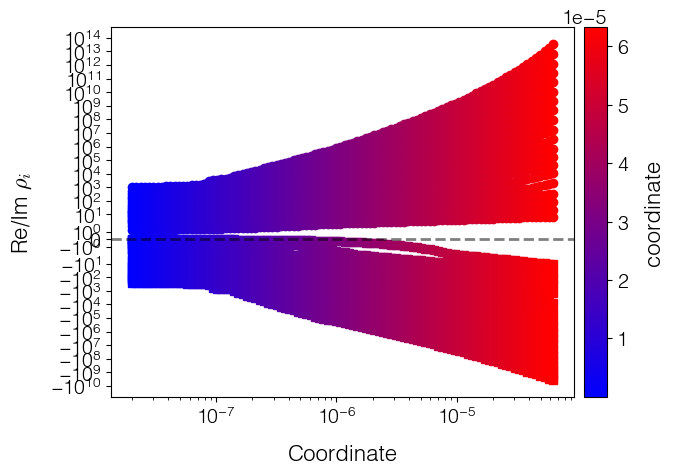

In [6]:
ProbeGapSpectroscopy.plot_eigenrhos_scatter(Nmodes=20,versus_coord=True)
plt.gcf().axes[0].set_xscale('log')

Text(0.5, 0, 'Gap size')

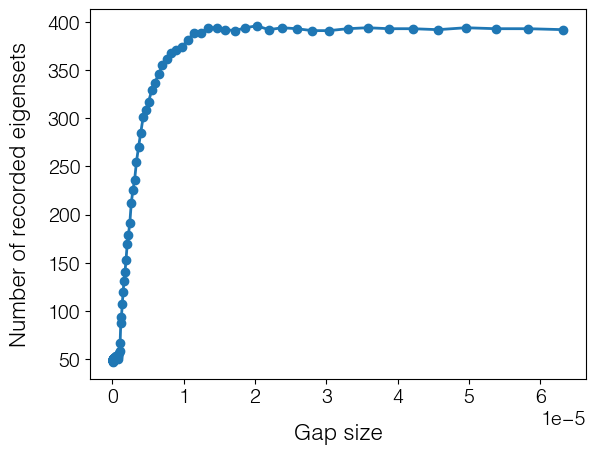

In [7]:
gaps = ProbeGapSpectroscopy._recorded_eigenrhos.keys()
Ns = [len(ProbeGapSpectroscopy._recorded_eigenrhos[gap]) for gap in gaps]
plt.plot(gaps,Ns,marker='o')
plt.ylabel('Number of recorded eigensets')
plt.xlabel('Gap size')

## Classify and plot dispersion of eignmodes with gap

In [8]:
Nmodes=50
ProbeGapSpectroscopy(Nmodes=Nmodes,reversed=True,by_rho=True,debug=False)
eigenrhos = ProbeGapSpectroscopy.get_eigenrhos_AWA(Nmodes=Nmodes)
eigencharges = ProbeGapSpectroscopy.get_eigencharges_AWA(Nmodes=Nmodes)

Classifying eigensets by eigenindex, with reversal...
Looking for Nmodes=47 (maximum uniformly available in coordinate range).
	Progress: 99.00%<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.align_eigencharge_signs>:
	Aligning signage of 47 eigenmode charges over 100 coordinates...


Text(0.5, 0, 'Gap/a')

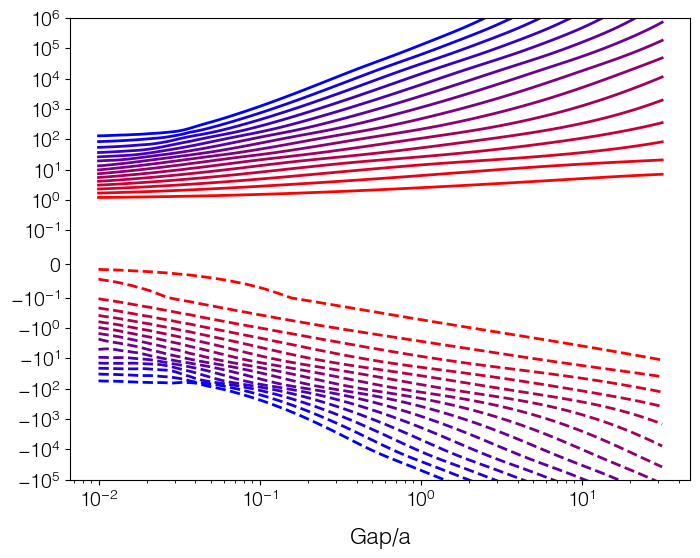

In [9]:
Nmodes_plot=15
colors=zip(np.linspace(1,0,Nmodes_plot),[0]*Nmodes_plot,np.linspace(0,1,Nmodes_plot))
plt.figure(figsize=(8,6))

a=P.get_a()
gaps=eigenrhos.axes[1]
for n in range(Nmodes_plot):
    c=next(colors)
    rhos=eigenrhos[n]
    plt.plot(gaps/a,rhos.real,marker='',color=c)
    plt.plot(gaps/a,rhos.imag,marker='',color=c,ls='--')
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e5,1e6)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.gca().set_xscale('log')
plt.xlabel('Gap/a')

## Compute brightness associated to eigenmodes

<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenbrightness_AWA>:
	Computing brightnesses across 100 spectroscopy coordinates...


Text(0.5, 1.0, 'Brightness')

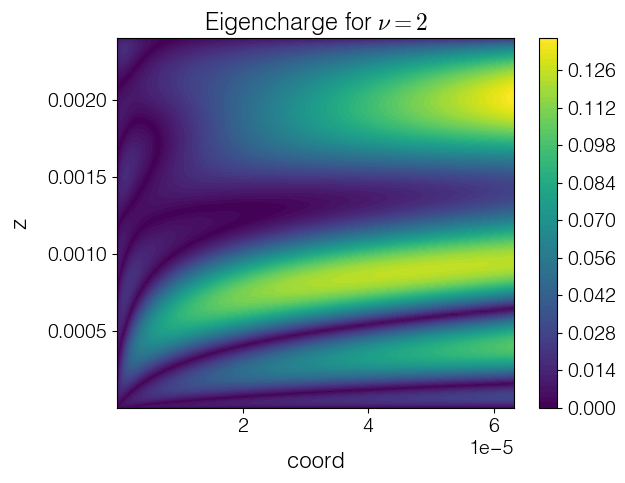

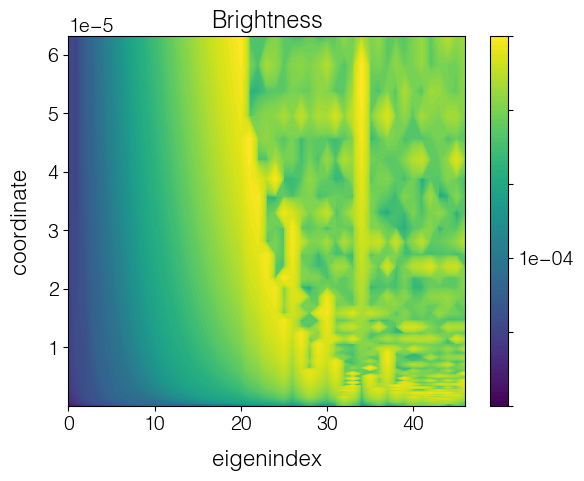

In [11]:
eigenind=2
np.abs(ProbeGapSpectroscopy._eigencharges_AWA[eigenind].real).plot(plotter=plt.contourf)
plt.title(r'Eigencharge for $\nu=%i$'%eigenind)

angles=np.linspace(10,90,20)
all_vs = ProbeGapSpectroscopy.get_eigenbrightness_AWA(Nmodes=Nmodes, recompute=True,
                                                eigencharges_AWA=ProbeGapSpectroscopy._eigencharges_AWA,
                                                angles=angles,
                                                verbose=True)
plt.figure()
np.abs(all_vs).plot(plotter=plt.contourf,log_scale=True)
plt.title('Brightness')

# Probe Frequency Spectroscopy

## Load or build spectroscopy

In [17]:
freqs=np.linspace(0.5,80,200)*freq_THz
reload(PS)

recompute=False

try:
    if recompute: raise ValueError
    ProbeFreqSpectroscopy = PCE.load(P, PS.ProbeFrequencySpectroscopyParallel, overwrite_probe=True)
    
except (FileNotFoundError,ValueError):
    ProbeFreqSpectroscopy = PS.ProbeFrequencySpectroscopyParallel(Probe=P, freqs=freqs,
                                                                 ncpus=8, backend='loky',
                                                                 Nmodes=20, reversed=False)
    PCE.save(ProbeFreqSpectroscopy,overwrite=True)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(Hyperboloid=20nm_L=23microns_Nnodes=488)_ProbeFrequencySpectroscopy.pickle"!


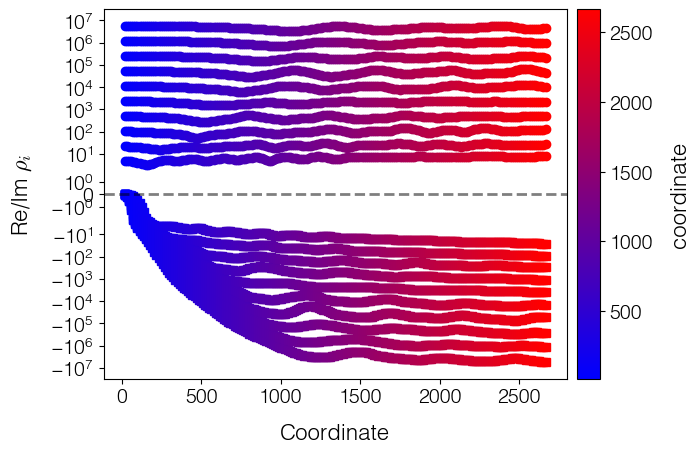

In [19]:
ProbeFreqSpectroscopy.plot_eigenrhos_scatter(Nmodes=10,versus_coord=True)
plt.gcf().axes[0].set_xscale('linear')

## Classify and plot dispersion of probe poles

In [20]:
ProbeFreqSpectroscopy(Nmodes=20,reverse=False,by_rho=True,debug=False)
eigenrhos = ProbeFreqSpectroscopy.get_eigenrhos_AWA(Nmodes=20)
eigencharges = ProbeFreqSpectroscopy.get_eigencharges_AWA(Nmodes=20)

Classifying eigensets by eigenindex...
	Progress: 99.50%<ProbeCavityEigenfields.ProbeSpectroscopy.ProbeFrequencySpectroscopyParallel.align_eigencharge_signs>:
	Aligning signage of 20 eigenmode charges over 200 coordinates...


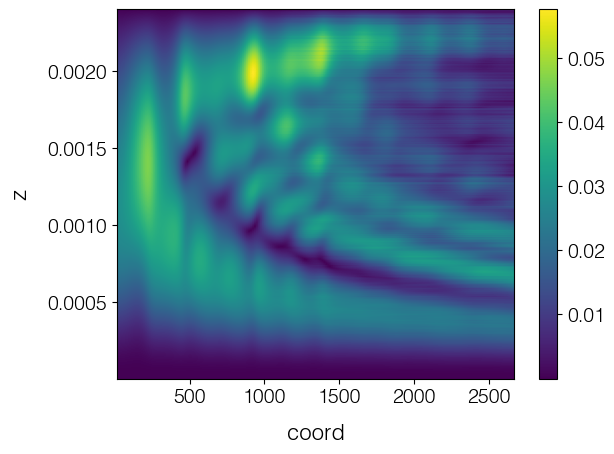

In [21]:
np.abs(eigencharges[0]).plot() # higher order eigencharges show some weird sharp defects (eigenvalue error?), but oh well

Text(0.5, 1.0, 'Hyperboloid=20nm_L=23microns_Nnodes=488')

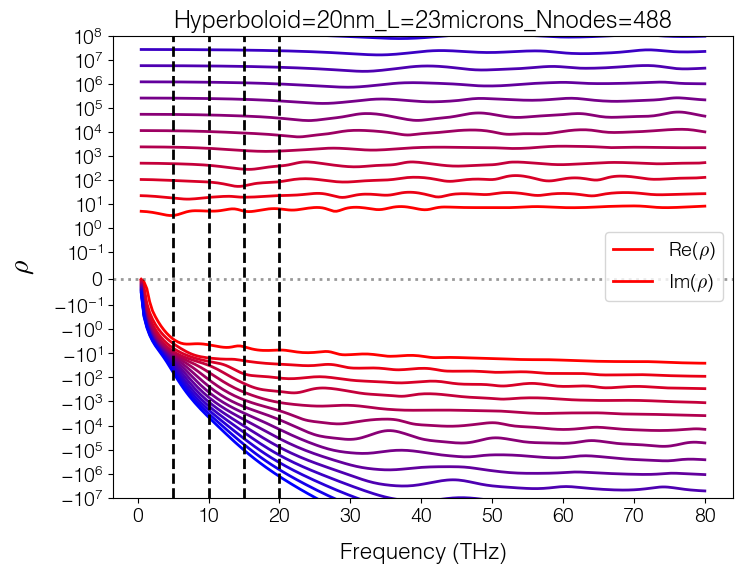

In [24]:
N=14
colors=zip(np.linspace(1,0,N),[0]*N,np.linspace(0,1,N))
plt.figure(figsize=(8,6))

freqs=eigenrhos.axes[1]
for n in range(N):
    c=next(colors)

    if n==0:
        label1=r'Re($\rho$)'
        label2=r'Im($\rho$)'
    else: label1=label2=None
        
    rhos=eigenrhos[n]
    plt.plot(freqs/freq_THz,rhos.real,marker='',color=c,label=label1)
    plt.plot(freqs/freq_THz,rhos.imag,marker='',color=c,label=label2)
    
plt.gca().set_yscale('symlog',linthresh=.1)
plt.ylim(-1e7,1e8)
#plt.xlim(.0074,.0076)
#plt.xlim(np.min(freqs),.002)
plt.xlabel('Frequency (THz)')
plt.ylabel(r'$\rho$',fontsize=20)
plt.legend(frameon=True)

#--- Plot some antenna mode frequencies

f=.8
plt.axvline(f/(2*L)/freq_THz,color='k',ls='--') #This is where probe ~ lambda/2 antenna - radiative Q?
plt.axvline(f/L/freq_THz,color='k',ls='--') #This is where probe ~ lambda antenna - radiative Q?
plt.axvline(f*3/(2*L)/freq_THz,color='k',ls='--')
plt.axvline(f*2/(L)/freq_THz,color='k',ls='--')

plt.axhline(0,ls=':',color='k',alpha=.4)
plt.title(ProbeFreqSpectroscopy.get_probe().get_name())